In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import *
from pathlib import Path
plt.style.use('plot_styles.txt')
import  matplotlib.font_manager
fpath = '/usr/local/share/fonts/HelveticaNeue.ttf'

# colorWheel =['#329932',
#             '#ff6961',
#             'b',
#             '#6a3d9a',
#             #'#fb9a99',
#             #'#e31a1c',
#             #'#fdbf6f',
#             #'#ff7f00',
#             #'#cab2d6',
#             #'#6a3d9a',
#             #'#ffff99',
#             #'#b15928',
#             #'#67001f',
#             '#b2182b',
#             #'#d6604d',
#             '#f4a582',
#             '#fddbc7',
#             '#f7f7f7',
#             '#d1e5f0',
#             '#92c5de',
#             '#4393c3',
#             '#2166ac',
#             '#053061']


colorWheel = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

curve_names = {
    'D': 'Parallel Dual Simplex',
    'DR': 'Dual Reducer',
    'GDR': 'Gurobi ILP',
    'SR': 'SketchRefine',
    'LSR': 'Progressive Shading',
    'DLV': 'Dynamic Low Variance'
}

lw=1
markersize=2
capsize=2
marker='o'
linestyle='-'
capsize=4
capthick=0.8
elinewidth=0.5
alpha=0.15
figsize=(12, 6)

plt.rcParams["font.family"] = "Helvetica Neue"

indexMap = {'GDR': 1, 'SR': 2, 'LSR': 0}
xOffsetMap = [0.8, 1.4, 1]

SMALL_SIZE = 12
MEDIUM_SIZE = 13
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#markers = ['o', 'P', 'd', 'v', '^']

# A3

                                y                            
                             mean          amax          amin
dataset solver x                                             
ssds    LSR    1.0       2.482570      5.000000      1.000000
               3.0       1.262558      1.762883      1.066891
               5.0       1.323973      1.696708      1.020140
               7.0       1.169631      1.335420      1.019406
               9.0       1.138165      1.312777      1.015518
               11.0      1.147702      1.337754      1.043167
               13.0      1.411745      3.019457      1.087820
               15.0      1.926650      4.438668      1.162944
        SR     1.0   40269.001586  41381.000000  36051.023797
tpch    LSR    1.0       1.000187      1.000286      1.000132
               3.0       1.000177      1.000249      1.000120
               5.0       1.000407      1.001095      1.000034
               7.0       1.000885      1.001859      1.000171
        

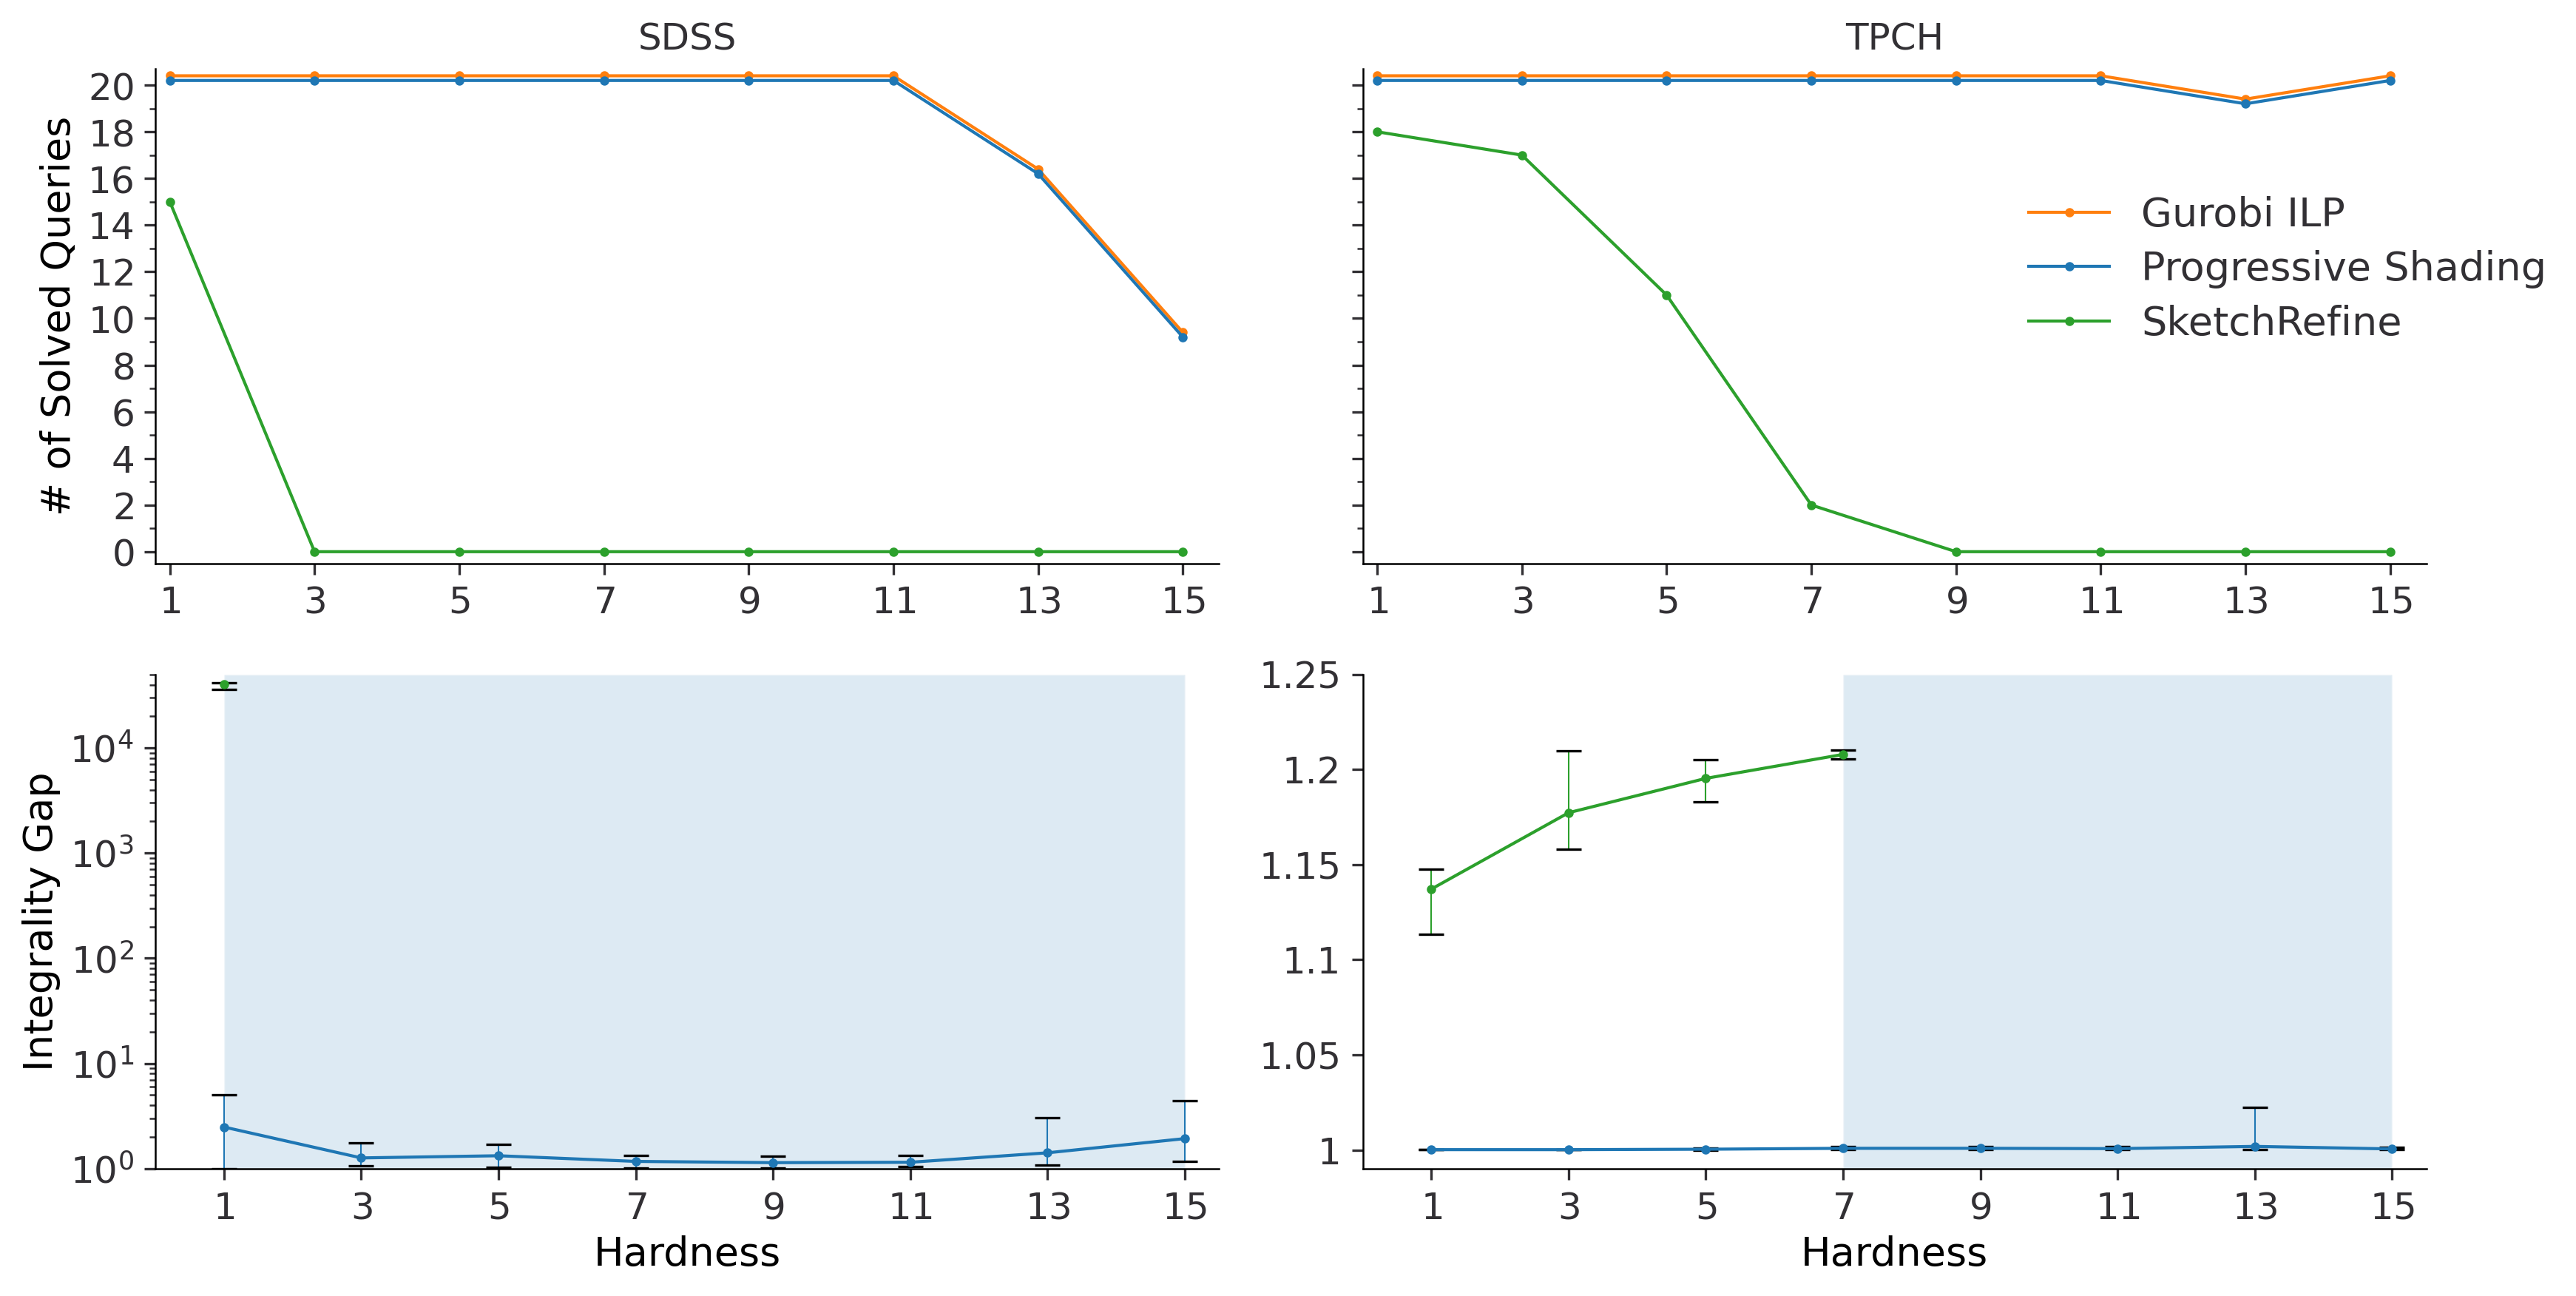

In [6]:
data = pd.read_csv('A3.csv', names=['curve', 'x', 'y'])
data['solver'] = data['curve'].str.partition('_')[2].str.partition('_')[0]
data['dataset'] = data['curve'].str.partition('_')[0]
# data.curve.str.extract('^(?:[^_]*_){2}(.+)$')
data['dparam'] = data.curve.str.rpartition('_')[2]
df_err = data[data['dparam']=='igap']
df_acc = data[~(data['dparam']=='igap')]

df_acc_agg = df_acc.groupby(['dataset', 'solver', 'x', 'dparam'], as_index=False)['y'].sum()
df_err_bar = df_err.groupby(['dataset', 'solver', 'x'], as_index=False).agg([np.mean, np.max, np.min])
print(df_err_bar)
df_err_bar.columns = df_err_bar.columns.map('_'.join)
df_err_bar.reset_index(inplace=True)
df_err_bar['y_err_pos'] = df_err_bar['y_amax'] - df_err_bar['y_mean']
df_err_bar['y_err_neg'] = df_err_bar['y_mean'] - df_err_bar['y_amin']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
xticks = list(range(1, 16, 2))
dataset = ['ssds', 'tpch']

for i, D in enumerate(dataset):
    df_acc_d = df_acc_agg[df_acc_agg['dataset']==D]
    df_err_d = df_err
    ax = axs[0, i]
    df_gr = df_acc_d[(df_acc_d['solver']=='LSR') & (df_acc_d['dparam']=='P')]\
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()

    df_lsr = df_acc_d[(df_acc_d['solver']=='LSR') & (df_acc_d['dparam']=='P')] \
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    df_sr = df_acc_d[(df_acc_d['solver']=='SR') & (df_acc_d['dparam']=='P')] \
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    
    # Impute missing data points explicitly with None value
    # if df_sr.shape[0] <= len(xticks):
    for x in xticks:
        new_row = pd.Series({'x': x, 'y': 0})
        if x not in df_sr.x.unique():
            df_sr = pd.concat([df_sr, new_row.to_frame().T], ignore_index=True)
        if x not in df_lsr.x.unique():
            df_lsr = pd.concat([df_lsr, new_row.to_frame().T], ignore_index=True)
        if x not in df_gr.x.unique():
            df_gr = pd.concat([df_gr, new_row.to_frame().T], ignore_index=True)
    
    ax.plot(
        df_gr['x'],
        df_gr['y']+0.4,
        color = colorWheel[indexMap['GDR']],
        linestyle=linestyle,
        lw=lw,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['GDR']],
        label='Gurobi ILP'
    )
    ax.plot(
        df_lsr['x'],
        df_lsr['y']+0.2,
        color = colorWheel[indexMap['LSR']],
        lw=lw,
        linestyle=linestyle,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['LSR']],
        label='Progressive Shading'
    )
    ax.plot(
        df_sr['x'],
        df_sr['y'],
        color = colorWheel[indexMap['SR']],
        lw=lw,
        linestyle=linestyle,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['SR']],
        label='SketchRefine'
    )
    if i!=0:
        ax.yaxis.set_tick_params(labelleft=False)
    if D == 'ssds':
        DD = 'SDSS'
    else:
        DD = 'TPCH'
    ax.set_title(DD, loc='center')
    ax.set_ylim(top=20.7, bottom=-0.5)
    ax.set_yticks(range(0, 21, 2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_xlim(left=0.8, right=15.5)
    ax.set_xticks(xticks)

    df_err_d = df_err_bar[df_err_bar['dataset']==D]
    max_other = 0
    max_lsr = 0
    for solver in ['LSR', 'SR']:
        df_curve_err = df_err_d[df_err_d['solver']==solver]
        ax1 = axs[1, i]
        ax1.errorbar(
                df_curve_err['x'], 
                df_curve_err['y_mean'], 
                yerr=[df_curve_err['y_err_neg'], df_curve_err['y_err_pos']],
                color=colorWheel[indexMap[solver]],
                linestyle=linestyle,
                linewidth=lw,
                marker=marker,
                markersize=markersize,
                markeredgecolor=colorWheel[indexMap[solver]],
                capsize=capsize,
                capthick=capthick,
                elinewidth=elinewidth,
                ecolor=colorWheel[indexMap[solver]]
            )
#         if i!=0:
#             ax1.yaxis.set_tick_params(labelleft=False)
        #ax1.set_xscale('log', base=10)
        ax1.yaxis.set_major_formatter(FuncFormatter('{:.5g}'.format))
        if i==0:
            ax1.set_yscale('log', base=10)
            ax1.set_ylim([0.99, 50000])
        else:
            ax1.set_ylim([0.99, 1.25])
        ax1.set_xticks(xticks)
        ax1.set_xlabel("Hardness")
        ax1.set_xlim(right=15.5)
        if solver == 'SR':
            max_other = df_curve_err['x'].max()
        else:
            max_lsr = df_curve_err['x'].max()
    ax1.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
        
axs[0, 0].set_ylabel('# of Solved Queries')
axs[1, 0].set_ylabel('Integrality Gap')
axs[0, 1].legend(frameon=False, bbox_to_anchor=(0.6, 0.8))
plt.tight_layout()

# A4 ssds

<ipython-input-10-4fcf323eb467>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_err.sort_values(['x'], inplace=True)


Text(0.5, 0.95, "SDSS's Hardness")

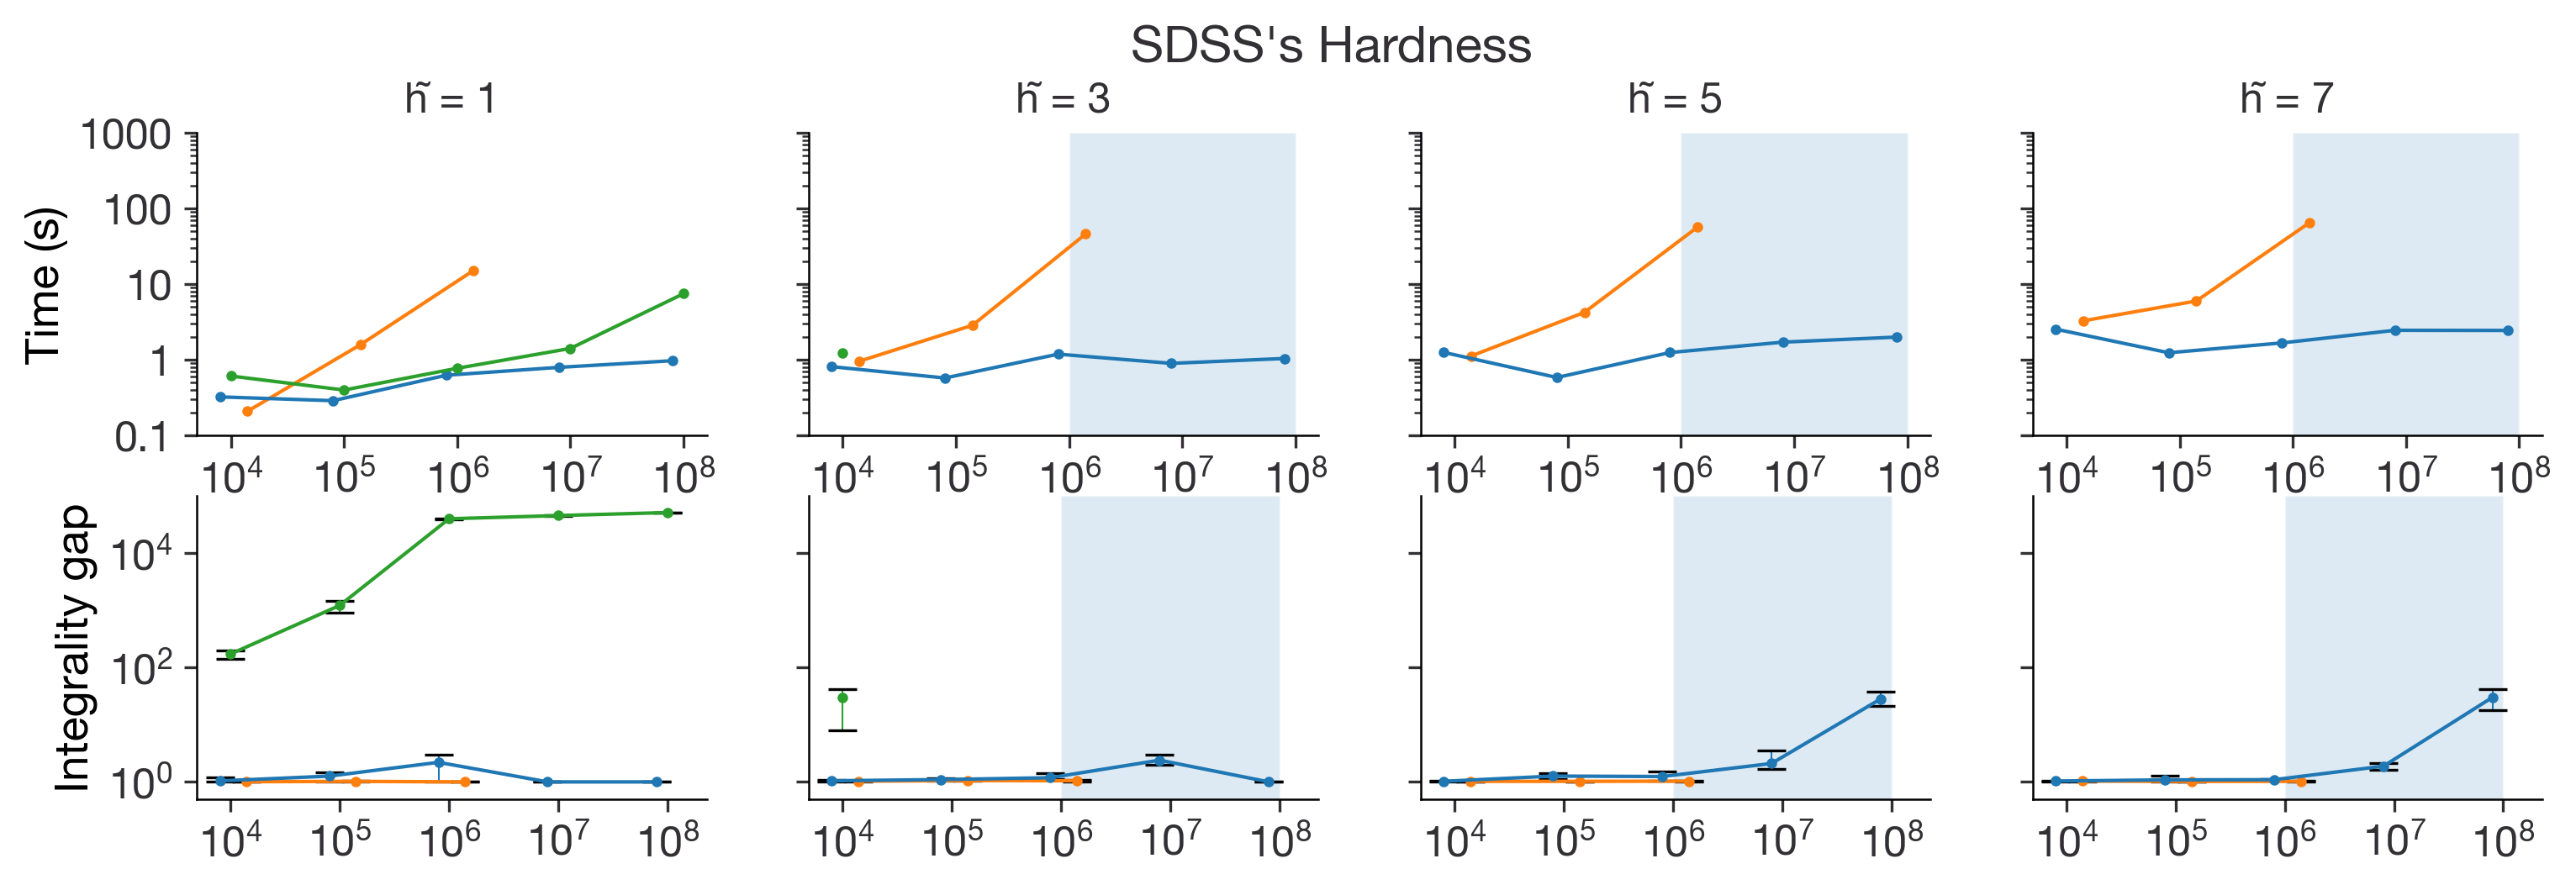

In [10]:
figsize=(12, 3.5)
csv_file = 'A4_ssds.csv'
is_ssds = 'ssds' in csv_file
data = pd.read_csv(csv_file, names=['curve', 'x', 'y'])
data['solver'] = data['curve'].str.rpartition('_')[0].str.rpartition('_')[2]
data['H'] = data['curve'].str.rpartition('_H')[2].str.partition('_')[0]
df_time = data[data['curve'].str.contains('time')]
df_err = data[data['curve'].str.contains('igap')]

df_time_avg = df_time.groupby(['solver', 'H', 'x'], as_index=False).mean()
df_err_avg = df_err.groupby(['solver', 'H', 'x'], as_index=False).mean()
df_err_bar = df_err.groupby(['solver', 'H', 'x'], as_index=False).agg([np.mean, np.max, np.min])
df_err_bar.columns = df_err_bar.columns.map('_'.join)
df_err_bar.reset_index(inplace=True)
df_err_bar['y_err_pos'] = df_err_bar['y_amax'] - df_err_bar['y_mean']
df_err_bar['y_err_neg'] = df_err_bar['y_mean'] - df_err_bar['y_amin']

num_hardness = data['H'].nunique()
fig, axs = plt.subplots(nrows=2, ncols=num_hardness, figsize=figsize)
xticks = df_time['x'].unique()
s_pos = np.array([np.logspace(0.8*x, 1.2*x, num=3) for x in xticks])
plt.rcParams["font.family"] = "Helvetica Neue"
for idx, h in enumerate(data['H'].unique()):
    df_h = df_time_avg[df_time_avg['H'] == h]
    df_h_err = df_err_bar[df_err_avg['H'] == h]
    ax = axs[0, idx]
    ax1 = axs[1, idx]
    max_other = 0
    for i, curve in enumerate(df_h['solver'].unique()):
        df_curve = df_h[df_h['solver'] == curve]
        df_curve_err = df_h_err[df_h_err['solver'] == curve]
        ax.plot(
            df_curve['x']*xOffsetMap[indexMap[curve]],
            df_curve['y']/1000,
            color=colorWheel[indexMap[curve]],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[indexMap[curve]],
            label=curve_names[curve]
        )
        if idx!=0:
            ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xscale('log', base=10)
        ax.set_yscale('log', base=10)
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.tick_params(axis='x', which='major')
        ax.set_ylim(bottom=0.1, top=10e2)
        ax.yaxis.set_major_formatter(FuncFormatter('{:.4g}'.format))
        ax.set_xticks(df_time['x'].unique())
        ax.set_title('h̃ = '+str(h), loc='center')
        if curve == 'LSR':
            max_lsr = df_curve['x'].max()
        else:
            max_other = max(df_curve['x'].max(), max_other)
        
        # Percentage Error Bar
        
        # Impute missing data points explicitly with None value
        if df_curve_err.shape[0] <= len(xticks):
            for x in xticks:
                if x not in df_curve_err.x.unique():
                    new_row = pd.Series({'solver': curve, 'x': x, 'H': h})
                    df_curve_err = pd.concat([df_curve_err, new_row.to_frame().T], ignore_index=True)
        df_curve_err.sort_values(['x'], inplace=True)
    

        ax1.errorbar(
            df_curve_err['x']*xOffsetMap[indexMap[curve]], 
            df_curve_err['y_mean'], 
            yerr=[df_curve_err['y_err_neg'], df_curve_err['y_err_pos']],
            color=colorWheel[indexMap[curve]],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[indexMap[curve]],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[indexMap[curve]],
            label=curve_names[curve]
        )
        if idx!=0:
            ax1.yaxis.set_tick_params(labelleft=False)
        ax1.set_xscale('log', base=10)
        if is_ssds:
            ax1.set_yscale('log', base=10)
            ax1.set_yticks([1,100,10000])
        def ff(num, s):
            import math
            p = int(math.log10(num))
#             return r'$10^' + str(p) + '$'
            return '$\mathregular{10^{' + str(p) + '}}$'
#         ax1.yaxis.set_major_formatter(FuncFormatter('{:.6g}'.format))
        ax1.yaxis.set_major_formatter(ff)
#         ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#         def custom_formatter(x, pos):
#             return f'{x:.0e}'
#         ax1.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

        ax1.set_xticks(df_time['x'].unique())
        ax1.tick_params(axis='x', which='major')
#         ax1.set_xlabel('Relation Size')
        if is_ssds:
            ax1.set_ylim(bottom=0.5, top=1e5)
        else:
            ax1.set_ylim(bottom=0.99, top=1.3)
    ax.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
    ax1.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
          
axs[0, 0].set_ylabel('Time (s)')
axs[1, 0].set_ylabel('Integrality gap')
# axs[1, 1].legend(frameon=False, bbox_to_anchor=(3, -0.3), ncols=3)
fig.supxlabel('SDSS\'s Hardness', x=0.5, y=0.95)


<ipython-input-8-8de5c92b27bd>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_err.sort_values(['x'], inplace=True)


Text(0.5, 0.95, "TPCH's Hardness")

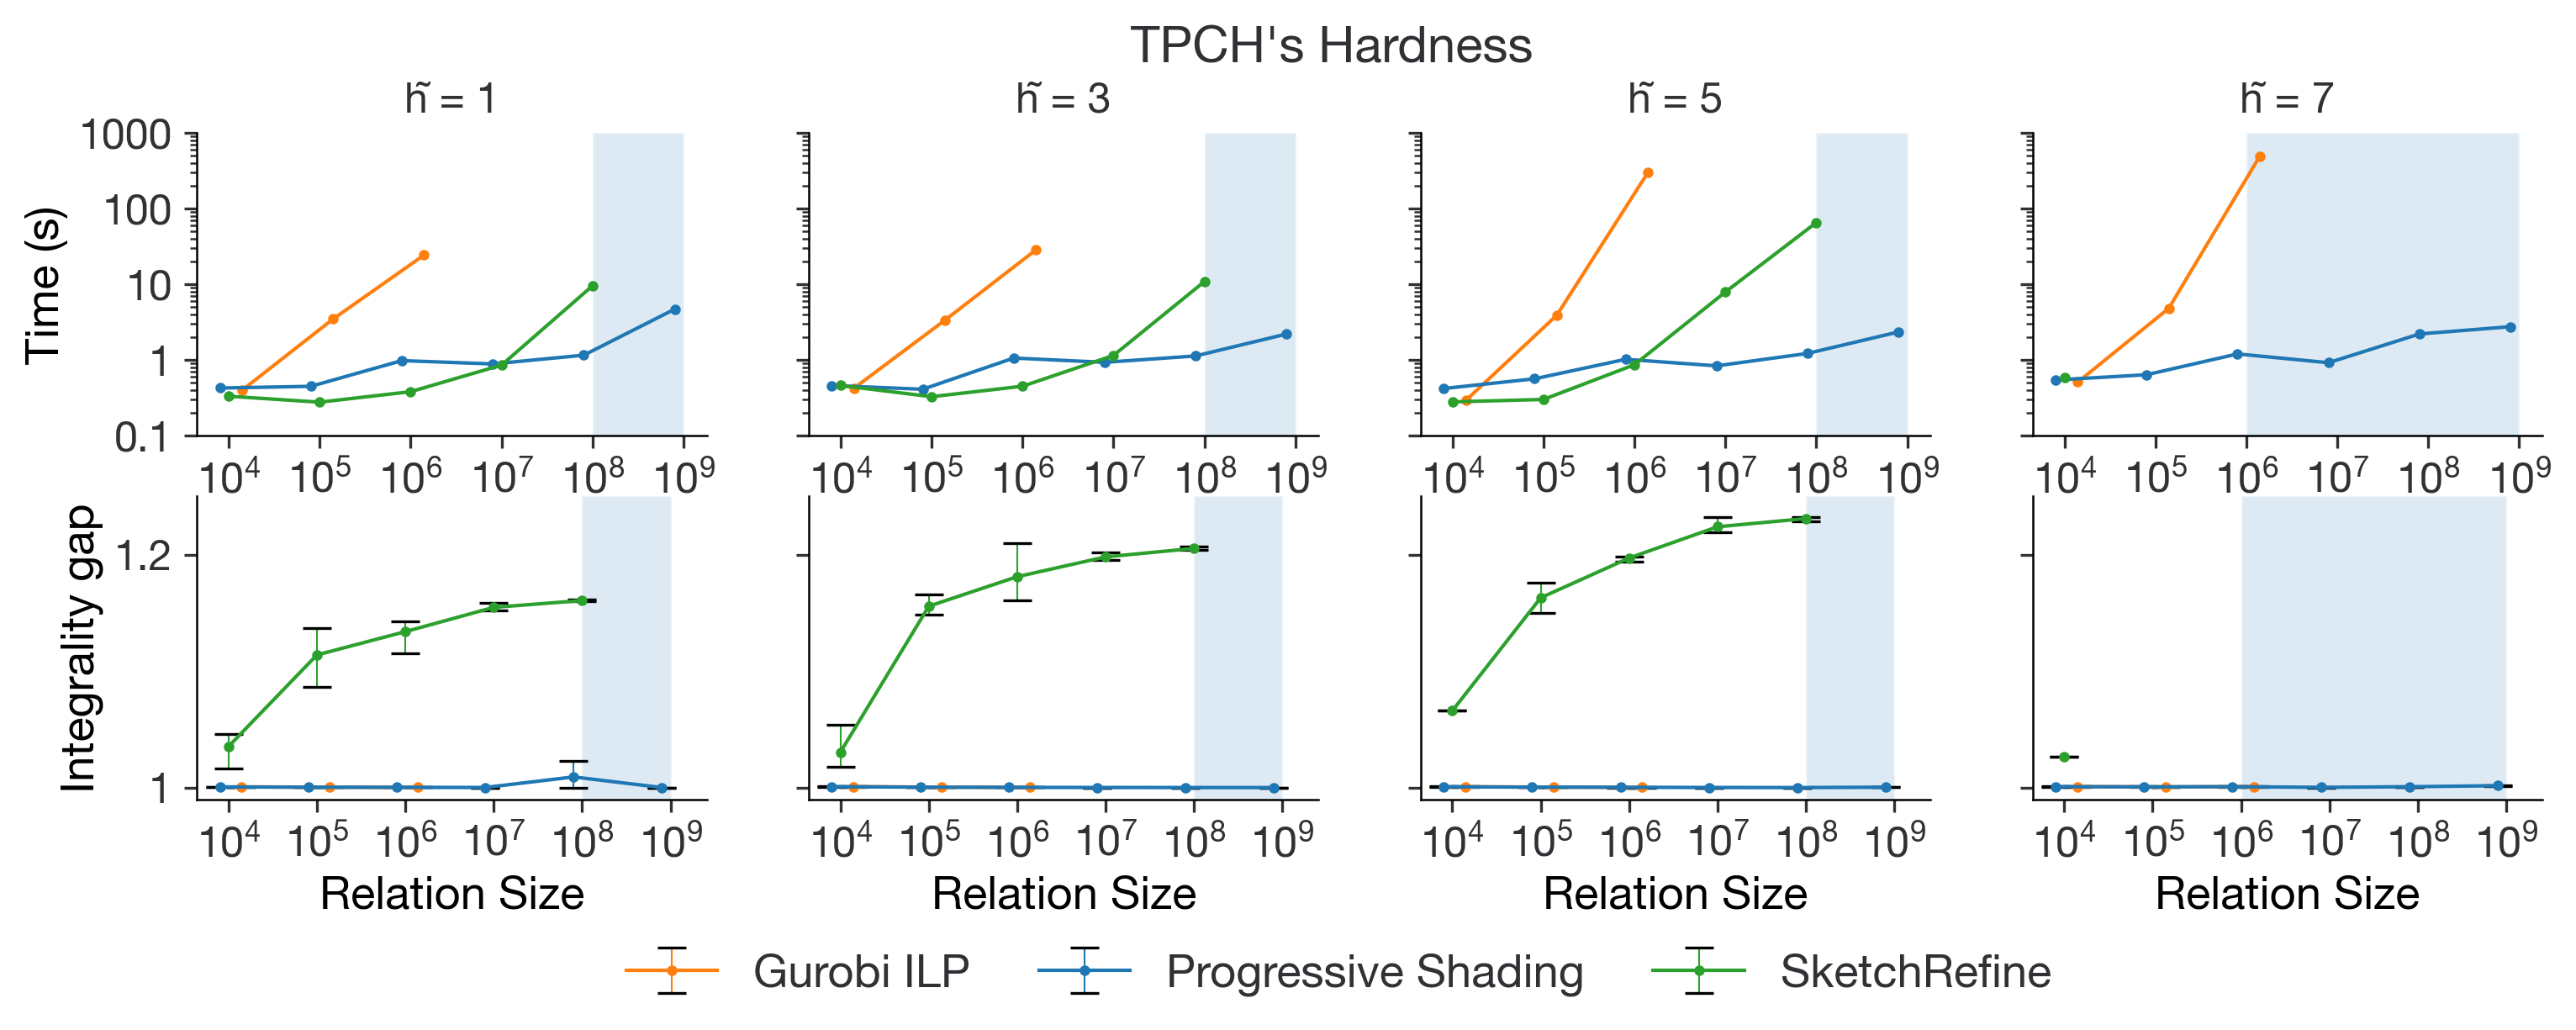

In [8]:
figsize=(12, 3.5)
csv_file = 'A4_tpch.csv'
is_ssds = 'ssds' in csv_file
data = pd.read_csv(csv_file, names=['curve', 'x', 'y'])
#data['x'] = dta['x'].astype(int)
data['solver'] = data['curve'].str.rpartition('_')[0].str.rpartition('_')[2]
data['H'] = data['curve'].str.rpartition('_H')[2].str.partition('_')[0]
df_time = data[data['curve'].str.contains('time')]
df_err = data[data['curve'].str.contains('igap')]

df_time_avg = df_time.groupby(['solver', 'H', 'x'], as_index=False).mean()
df_err_avg = df_err.groupby(['solver', 'H', 'x'], as_index=False).mean()
#df_err.y = df_err.y * 100
df_err_bar = df_err.groupby(['solver', 'H', 'x'], as_index=False).agg([np.mean, np.max, np.min])
df_err_bar.columns = df_err_bar.columns.map('_'.join)
df_err_bar.reset_index(inplace=True)
df_err_bar['y_err_pos'] = df_err_bar['y_amax'] - df_err_bar['y_mean']
df_err_bar['y_err_neg'] = df_err_bar['y_mean'] - df_err_bar['y_amin']

num_hardness = data['H'].nunique()
fig, axs = plt.subplots(nrows=2, ncols=num_hardness, figsize=figsize)
xticks = df_time['x'].unique()
s_pos = np.array([np.logspace(0.8*x, 1.2*x, num=3) for x in xticks])

for idx, h in enumerate(data['H'].unique()):
    df_h = df_time_avg[df_time_avg['H'] == h]
    df_h_err = df_err_bar[df_err_avg['H'] == h]
    ax = axs[0, idx]
    ax1 = axs[1, idx]
    max_other = 0
    for i, curve in enumerate(df_h['solver'].unique()):
        df_curve = df_h[df_h['solver'] == curve]
        df_curve_err = df_h_err[df_h_err['solver'] == curve]
        ax.plot(
            df_curve['x']*xOffsetMap[indexMap[curve]],
            df_curve['y']/1000,
            color=colorWheel[indexMap[curve]],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[indexMap[curve]],
            label=curve_names[curve]
        )
        if idx!=0:
            ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xscale('log', base=10)
        ax.set_yscale('log', base=10)
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.tick_params(axis='x', which='major')
        #ax.set_xlabel('Relation Size')
        ax.set_ylim(bottom=0.1, top=10e2)
        ax.yaxis.set_major_formatter(FuncFormatter('{:.4g}'.format))
        #ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
        #ax.yaxis.set_tick_params()
        ax.set_xticks(df_time['x'].unique())
        ax.set_title('h̃ = '+str(h), loc='center')
        if curve == 'LSR':
            max_lsr = df_curve['x'].max()
        else:
            max_other = max(df_curve['x'].max(), max_other)
        
        # Percentage Error Bar
        
        # Impute missing data points explicitly with None value
        if df_curve_err.shape[0] <= len(xticks):
            for x in xticks:
                if x not in df_curve_err.x.unique():
                    new_row = pd.Series({'solver': curve, 'x': x, 'H': h})
                    df_curve_err = pd.concat([df_curve_err, new_row.to_frame().T], ignore_index=True)
        df_curve_err.sort_values(['x'], inplace=True)
        
#         print("h", h)
#         print(df_curve_err['y_mean'])

        ax1.errorbar(
            df_curve_err['x']*xOffsetMap[indexMap[curve]], 
            df_curve_err['y_mean'], 
            yerr=[df_curve_err['y_err_neg'], df_curve_err['y_err_pos']],
            color=colorWheel[indexMap[curve]],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[indexMap[curve]],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[indexMap[curve]],
            label=curve_names[curve]
        )
        if idx!=0:
            ax1.yaxis.set_tick_params(labelleft=False)
        ax1.set_xscale('log', base=10)
        if is_ssds:
            ax1.set_yscale('log', base=10)
        ax1.yaxis.set_major_formatter(FuncFormatter('{:.5g}'.format))
        ax1.set_xticks(df_time['x'].unique())
#         ax1.set_xlabels(['10e4', '10e5', '10e6', '10e7', '10e8', '10e9'])
#         ax1.ticklabel_format(axis='x', stylr='sci')
        ax1.tick_params(axis='x', which='major')
        ax1.set_xlabel('Relation Size')
        if is_ssds:
            ax1.set_ylim(bottom=0.9, top=1e5)
        else:
            ax1.set_ylim(bottom=0.99, top=1.25)
    ax.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
    ax1.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
          
axs[0, 0].set_ylabel('Time (s)')
#axs[0, 0].set_yticks([10])
axs[1, 0].set_ylabel('Integrality gap')
axs[1, 1].legend(frameon=False, bbox_to_anchor=(2.5, -0.4), ncols=3)
#axs[0, 0]
fig.supxlabel('TPCH\'s Hardness', x=0.5, y=0.95)
# plt.tight_layout()